# Post-WTMM analysis of terminus positions

By Jukes Liu

_Last modified 05-07-2020._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

basepath = '/home/jukes/Documents/Sample_glaciers/'

os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import midpoint

### Grab the BoxIDs

In [2]:
downloaded_df = pd.read_csv(basepath+'Images_downloaded_sample5.csv', sep=',', dtype=str)
downloaded_df = downloaded_df.set_index('BoxID')
# # pathrows_df = pathrows_df.drop('215')
# pathrows_df
BoxIDs = list(downloaded_df.index)
print(BoxIDs)

['120', '174', '259', '002', '001']


# 1) Grab the vertices of the glacier terminus boxes in pixel coordinates

The vertices of the glacier terminus box will be used to calculate a midpoint of the left edge of the terminus box, which will be our reference point for calculating terminus position.

In [16]:
#create dictionary to store each terminus box ndarray by BoxID
termboxes = {}

#read in the terminus box rasters
for BoxID in BoxIDs:
    #load in the raster
#     boxpath = basepath+"Box"+BoxID+"/rotated_images/final/crop_Box"+BoxID+"_raster_cut.pgm"
    boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated_c1/R_Box"+BoxID+"_raster_cut.pgm"
    #read the raster into an ndarray
    termbox = mpimg.imread(boxpath)
    #add the ndarray into a dictionary with the BoxID as the key
    termboxes.update( {BoxID: termbox} )

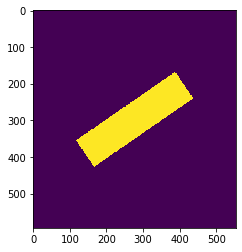

In [17]:
#visualize each terminus box rasters by BoxID
termplot = plt.imshow(termboxes['259'])
plt.show()

#### Find x,y coordinates of box vertices and midpoints of left and right edges to get the centerline

In [12]:
#create dictionary to store the all coordinates of the box rasters
boxes_xcoords = {}; boxes_ycoords = {}

#create dictionaries for the box vertices
topleft_coords = {}; bottomleft_coords = {}; topright_coords = {} ;bottomright_coords = {}

#create lists to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = []; midpoints_y = []; midpoints_r_x = []; midpoints_r_y = []
mids_l025_x = []; mids_l025_y = []; mids_r025_x = []; mids_r025_y = []
mids_l075_x = []; mids_l075_y = []; mids_r075_x = []; mids_r075_y = []

#create lists to store the slopes and intercepts of the centerline equations
slope_50 = []; intercept_50 = []; slope_25 = []; intercept_25 = []; slope_75 = []; intercept_75 = []; boxes = []

#for all the box rasters
for BoxID in BoxIDs:
    BOI = termboxes[BoxID] #Read in the raster of the BoxID of interest
    yindices, xindices = np.where(BOI > 0) #keep the pixels of where thevalue is nonzero (where the box exists)
    boxes_ycoords.update( {BoxID: yindices}); boxes_xcoords.update( {BoxID: xindices}) #add box coordinates to the dictionary
    
    if BoxID == '259':
        topleft = [117.0, 355.0]
        bottomleft = [166.0, 426.0]
        topright = [386.0, 169.0]
        bottomright = [435.0, 239.0]
    else:
        #1A) FIND THE TOP LEFT COORDINATES (min x and min y)
        xy = xindices*yindices
        min_xy_i = np.where(xy == np.min(xy))[0][0]  #Find the x and y pair corresponding to that lowest xy

        topleft = [xindices[min_xy_i], yindices[min_xy_i]]

        #2B) FIND THE BOTTOM RIGHT COORDINATES (highest x*y)
        max_xy = np.max(xy)
        max_xy_i = np.where(xy == max_xy)[0][0]
        bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
        
        #1B) FIND THE BOTTOM LEFT COORDINATE(highest y/x)
        y_x = yindices/xindices
        max_y_x = np.max(y_x) #Find the highest y/x value
        #Find the x and y pair corresponding to that y/x using the index
        max_y_x_i = np.where(y_x == max_y_x)[0][0]
        bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
        
        #2A) FIND THE TOP RIGHT COORDINATES (highest x/y)
        x_y = xindices/yindices
        max_x_y = np.max(x_y)  # find highest x/y value
        max_x_y_i = np.where(x_y == max_x_y)[0][0]  #Find the x, y pair correpsonding to the maximum x/y using the index
        topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
        
    topleft_coords.update(  {BoxID: topleft}  )     #Add to dictionary of topleft coordinates
    bottomright_coords.update( {BoxID: bottomright})
    bottomleft_coords.update( {BoxID: bottomleft}  ) #Add to dictionary of bottomleft coordinates
    topright_coords.update( {BoxID: topright} )
    
    #1C and 2C) CALCULATE THE MIDPOINTS USING MIDPOINT FUNCTION
    #Left
    midpoint_x, midpoint_y = midpoint(topleft[0], topleft[1], bottomleft[0], bottomleft[1])
    #Right
    midpoint_r_x, midpoint_r_y = midpoint(topright[0], topright[1], bottomright[0], bottomright[1])
    
    #GRAB 1/4th and 3/4ths lines (midpoints)
    mid_l025_x, mid_l025_y = midpoint(topleft[0], topleft[1], midpoint_x, midpoint_y)
    mid_r025_x, mid_r025_y = midpoint(topright[0], topright[1], midpoint_r_x, midpoint_r_y) 
    mid_l075_x, mid_l075_y = midpoint(bottomleft[0], bottomleft[1], midpoint_x, midpoint_y)
    mid_r075_x, mid_r075_y = midpoint(bottomright[0], bottomright[1], midpoint_r_x, midpoint_r_y)
    
    #3) CALCULATE CENTERLINE EQUATIONS (y_intercept = y1 - m*x1)
    #1/2
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x);b = midpoint_y - (m*midpoint_x)
    #1/4
    m025 = (mid_r025_y-mid_l025_y)/(mid_r025_x-mid_l025_x); b025 = mid_l025_y - (m*mid_l025_x)
    #3/4
    m075 = (mid_r075_y-mid_l075_y)/(mid_r075_x-mid_l075_x); b075 = mid_l075_y - (m*mid_l075_x)
    
    #append BoxIDs, slopes, intercepts, midpoints, and centerlines to lists
    boxes.append(BoxID);
    midpoints_x.append(midpoint_x); midpoints_y.append(midpoint_y)
    midpoints_r_x.append(midpoint_r_x); midpoints_r_y.append(midpoint_r_y)  
    mids_l025_x.append(mid_l025_x); mids_l025_y.append(mid_l025_y); 
    mids_r025_x.append(mid_r025_x); mids_r025_y.append(mid_r025_y)
    mids_l075_x.append(mid_l075_x) ;mids_l075_y.append(mid_l075_y) ;
    mids_r075_x.append(mid_r075_x) ;mids_r075_y.append(mid_r075_y)
    slope_50.append(m); intercept_50.append(b); 
    slope_25.append(m025); intercept_25.append(b025)
    slope_75.append(m075); intercept_75.append(b075)
    
#create a dataframe
total_df = pd.DataFrame(list(zip(boxes, midpoints_x, midpoints_y, midpoints_r_x, midpoints_r_y, slope_50, 
                                 intercept_50, mids_l025_x, mids_l025_y, mids_r025_x, mids_r025_y, slope_25, 
                                 intercept_25, mids_l075_x, mids_l075_y, mids_r075_x, mids_r075_y, slope_75, 
                                intercept_75)), 
                        columns=['BoxID', 'lmid50_x', 'lmid50_y', 'rmid50_x','rmid50_y', 'm50', 'b50',
                                 'lmid25_x', 'lmid25_y','rmid25_x','rmid25_y', 'm25', 'b25',
                                 'lmid75_x', 'lmid75_y', 'rmid75_x','rmid75_y', 'm75', 'b75'])

total_df = total_df.drop_duplicates().set_index('BoxID')
total_df

,lmid50_x,lmid50_y,rmid50_x,rmid50_y,m50,b50,lmid25_x,lmid25_y,rmid25_x,rmid25_y,m25,b25,lmid75_x,lmid75_y,rmid75_x,rmid75_y,m75,b75
BoxID,,,,,,,,,,,,,,,,,,
120,68.5,99.0,139.0,113.5,0.205674,84.911348,71.75,84.00,142.00,98.25,0.202847,69.242908,65.25,114.00,136.00,128.75,0.208481,100.579787
174,148.5,222.5,285.5,203.5,-0.138686,243.094891,144.75,194.75,281.25,175.25,-0.142857,214.824818,152.25,250.25,289.75,231.75,-0.134545,271.364964
259,141.5,390.5,410.5,204.0,-0.693309,488.603160,129.25,372.75,398.25,186.50,-0.692379,462.360130,153.75,408.25,422.75,221.50,-0.694238,514.846190
002,406.5,524.5,689.0,500.0,-0.086726,559.753982,403.25,486.25,686.00,462.00,-0.085765,521.222124,409.75,562.75,692.00,538.00,-0.087688,598.285841
001,101.0,142.0,174.5,148.0,0.081633,133.755102,102.00,132.50,174.75,138.00,0.075601,124.173469,100.00,151.50,174.25,158.00,0.087542,143.336735


### Another visual check

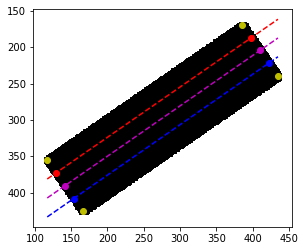

In [13]:
# Choose which glacier BoxID to check:
BOI_ID = '259'

# plot the raster pixels in black
plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k',marker='s')
#plot the vertices
plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='y')
plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='y')
plt.scatter(topright_coords[BOI_ID][0], topright_coords[BOI_ID][1], c='y')
plt.scatter(bottomright_coords[BOI_ID][0], bottomright_coords[BOI_ID][1], c='y')
#plot midpoints
plt.scatter(total_df.at[BOI_ID,'lmid50_x'], total_df.at[BOI_ID,'lmid50_y'], c='m'); plt.scatter(total_df.at[BOI_ID, 'rmid50_x'], total_df.at[BOI_ID, 'rmid50_y'], c='m')
plt.scatter(total_df.at[BOI_ID,'lmid25_x'], total_df.at[BOI_ID,'lmid25_y'], c='r'); plt.scatter(total_df.at[BOI_ID, 'rmid25_x'], total_df.at[BOI_ID, 'rmid25_y'], c='r')
plt.scatter(total_df.at[BOI_ID,'lmid75_x'], total_df.at[BOI_ID,'lmid75_y'], c='b'); plt.scatter(total_df.at[BOI_ID, 'rmid75_x'], total_df.at[BOI_ID, 'rmid75_y'], c='b')
# plot the centerlines in cyan
x=np.linspace(np.min(boxes_xcoords[BOI_ID]), np.max(boxes_xcoords[BOI_ID])); y50=(total_df.at[BOI_ID, 'm50'])*x + (total_df.at[BOI_ID, 'b50']); 
y25=(total_df.at[BOI_ID, 'm25'])*x + (total_df.at[BOI_ID, 'b25']); y75=(total_df.at[BOI_ID, 'm75'])*x + (total_df.at[BOI_ID, 'b75'])
plt.plot(x, y50, '--m', x, y25, '--r', x, y75, '--b')
# plot parameters      
plt.gca().invert_yaxis(); plt.axis('scaled'); plt.show()

### Drop the right midpoints and write the centerline information to a csv

In [14]:
total_df = total_df.drop(['rmid50_y', 'rmid25_y', 'rmid75_y'], axis=1)
total_df.head(10)

,lmid50_x,lmid50_y,rmid50_x,m50,b50,lmid25_x,lmid25_y,rmid25_x,m25,b25,lmid75_x,lmid75_y,rmid75_x,m75,b75
BoxID,,,,,,,,,,,,,,,
120,68.5,99.0,139.0,0.205674,84.911348,71.75,84.00,142.00,0.202847,69.242908,65.25,114.00,136.00,0.208481,100.579787
174,148.5,222.5,285.5,-0.138686,243.094891,144.75,194.75,281.25,-0.142857,214.824818,152.25,250.25,289.75,-0.134545,271.364964
259,141.5,390.5,410.5,-0.693309,488.603160,129.25,372.75,398.25,-0.692379,462.360130,153.75,408.25,422.75,-0.694238,514.846190
002,406.5,524.5,689.0,-0.086726,559.753982,403.25,486.25,686.00,-0.085765,521.222124,409.75,562.75,692.00,-0.087688,598.285841
001,101.0,142.0,174.5,0.081633,133.755102,102.00,132.50,174.75,0.075601,124.173469,100.00,151.50,174.25,0.087542,143.336735


In [15]:
CLINE_NAME = 'Boxes_coords_pathrows_sample5.csv'
total_df.to_csv(path_or_buf = basepath+CLINE_NAME, sep=',')

# 2) Calculate terminus position time series

In [3]:
# IMPORT THE FUNCTION
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import results_allglaciers

(2597, 2)
Box120
(1111, 4)
Dropping 13 dips
Dropping 18 dips
Dropping 34 dips
Dropping 38 jumps
Dropping 84 jumps
Dropping 58 jumps
212
198
200


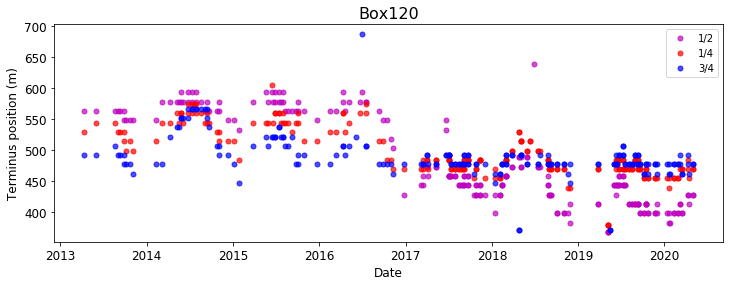

Box174
(664, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 39 dips
Dropping 25 dips
Dropping 48 dips
Dropping 45 jumps
Dropping 24 jumps
Dropping 35 jumps
123
122
104


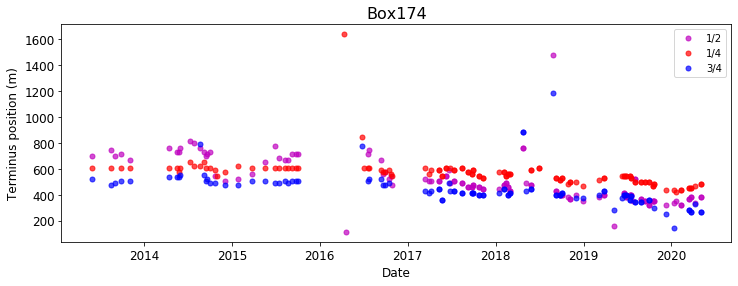

Box259
(753, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 93 dips
Dropping 122 dips
Dropping 57 dips
Dropping 142 jumps
Dropping 100 jumps
Dropping 80 jumps
114
101
80


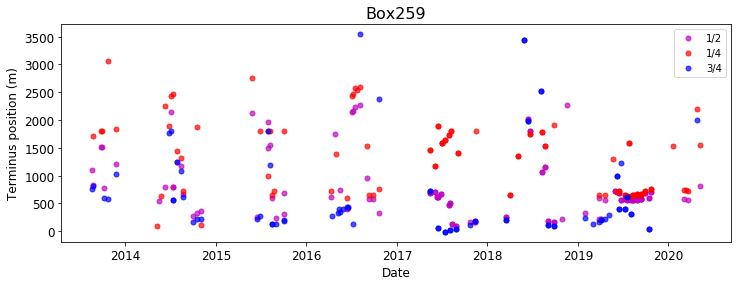

Box002
(639, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 189 dips
Dropping 116 dips
Dropping 99 dips
Dropping 141 jumps
Dropping 108 jumps
Dropping 100 jumps
104
83
89


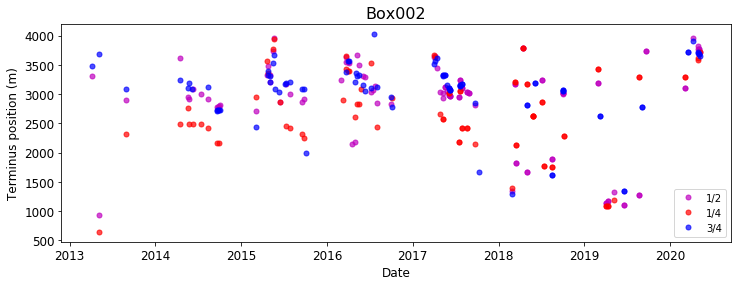

Box001
(1947, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 400 dips
Dropping 304 dips
Dropping 306 dips
Dropping 267 jumps
Dropping 219 jumps
Dropping 234 jumps
285
278
273


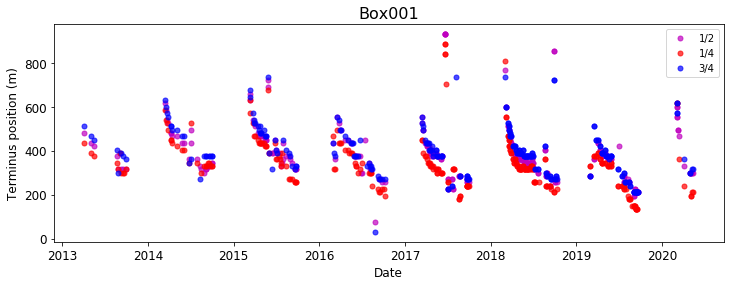

In [5]:
# first number is maximum flow speed scalar, second is number of remove dip iterations, third is remove jumps
# results_allglaciers(date_csv, centerline_csv, vel_csv, analysis_date, V, N1, N2):

results_allglaciers('Images_downloaded_sample5.csv','imgdates_sample10.csv', 'Boxes_coords_pathrows_sample5.csv','Glacier_vel_measures_sample10.csv', '2020_05_23', 3, 1, 1)